In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Reading the python file

In [ ]:
f = open("/gdrive/Shareddrives/_Research Repository - Mostafa Ebrahimi Meimand/Working Papers/++MPC for a building/Building Model/Hello1.py")
text = f.read()

## Thermal comfort dataset

In [ ]:
Profiles_Dataset = pd.DataFrame()
Profiles_Dataset["index"] = range(0,1201)

Thermal_Preferences = [23.67,24.69,22.76,21.49,20.05,23.99,22.09,23.02,20.82,25.55,22.22,27.31,20.26,21.74,25.16]

In [ ]:
for k in range(1,16):
  temp = pd.read_csv("/gdrive/Shareddrives/_Research Repository - Mostafa Ebrahimi Meimand/Working Papers/++HVAC controller integrated with Personal Thermal Comfort and Real Time Price/Thermal Comfort/" + str(k) + ".csv", header = None)
  
  temp = temp.loc[0] # Changing to a column
  temp = pd.DataFrame(temp) # changing to a dataframe
  temp = temp.rename(columns={0: str("Probability" + str(k))}) # renaming the column

  index = temp[temp[str("Probability" + str(k))] == 1].index[0] # getting where is the maximum value

  # Adding probabilities
  temp[str("Temperature" + str(k))] = None
  temp[str("Temperature" + str(k))][index] = Thermal_Preferences[k-1] # Thermal Preference

  for i in range(index - 1,-1,-1):
    temp[str("Temperature" + str(k))][i] = temp[str("Temperature" + str(k))][i + 1] - 0.01

  for i in range(index + 1, temp.shape[0]):
    temp[str("Temperature" + str(k))][i] = temp[str("Temperature" + str(k))][i - 1] + 0.01

  temp[str("Temperature" + str(k))] = temp[str("Temperature" + str(k))].astype(float).round(2)
  temp["index"] = temp.index

  Profiles_Dataset = pd.merge(Profiles_Dataset, temp, on = "index")

## Comparing numbers

In [ ]:
temp = pd.read_csv("/gdrive/Shareddrives/_Research Repository - Mostafa Ebrahimi Meimand/Working Papers/++MPC for a building/Building Model/E+Validation/" + '23' + ".csv")

temp = temp.drop(temp.index[0:192],axis = 0)
temp = temp.reset_index()
temp = temp.drop("index", axis = 1)

# Adding dates to the dataset
delimiters = " ", ":", "/"
regexPattern = '|'.join(map(re.escape, delimiters))
temp["Month"] = None
temp["Day"] = None
temp["Hour"] = None
temp["Minutes"] = None

for i in range(temp.shape[0]):
  temp["Month"][i] = int(re.split(regexPattern,temp["Date/Time"][i])[1])
  temp["Day"][i] = int(re.split(regexPattern,temp["Date/Time"][i])[2])
  temp["Hour"][i] = int(re.split(regexPattern,temp["Date/Time"][i])[4])
  temp["Minutes"][i] = int(re.split(regexPattern,temp["Date/Time"][i])[5])

temp = temp[temp["Day"] == 1]

temp["CENTRAL SYSTEM_UNIT1:Air System Electricity Energy [J](TimeStep)"] *= 2.77778e-7

In [ ]:
temp.columns

Index(['Date/Time',
       'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)',
       'LIVING_UNIT1:Zone People Occupant Count [](TimeStep)',
       'LIVING_UNIT1:Zone Mean Air Temperature [C](TimeStep)',
       'ATTIC_UNIT1:Zone Mean Air Temperature [C](TimeStep)',
       'LIVING_UNIT1:Zone Air System Sensible Heating Energy [J](TimeStep)',
       'LIVING_UNIT1:Zone Air System Sensible Cooling Energy [J](TimeStep)',
       'LIVING_UNIT1:Zone Thermostat Cooling Setpoint Temperature [C](TimeStep)',
       'ATTIC_UNIT1:Zone Air System Sensible Heating Energy [J](TimeStep)',
       'ATTIC_UNIT1:Zone Air System Sensible Cooling Energy [J](TimeStep)',
       'ATTIC_UNIT1:Zone Thermostat Cooling Setpoint Temperature [C](TimeStep)',
       'HTGSETP_SCH:Schedule Value [](TimeStep)',
       'CLGSETP_SCH:Schedule Value [](TimeStep)',
       'MAIN ELECTRIC HEATING COIL_UNIT1:Heating Coil Heating Energy [J](Hourly)',
       'DX COOLING COIL_UNIT1:Cooling Coil Total Cooling Energy [J]

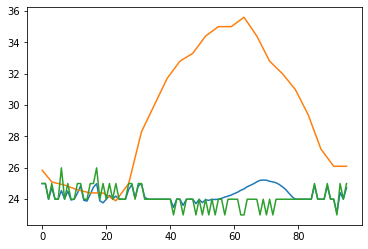

In [ ]:
temp["LIVING_UNIT1:Zone Mean Air Temperature [C](TimeStep)"].plot()
temp["Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)"].plot()
temp["CLGSETP_SCH:Schedule Value [](TimeStep)"].plot()

#### Energy

In [ ]:
t = [(0.92+0.3)/2,(0.73+0.64)/2, (0.93+0.45)/2, (0.9+0.23)/2]

In [ ]:
t

[0.61, 0.685, 0.6900000000000001, 0.5650000000000001]

In [ ]:
np.mean(t)

0.6375

In [ ]:
np.std(t)

0.052500000000000005

In [ ]:
temp["CENTRAL SYSTEM_UNIT1:Air System Electricity Energy [J](TimeStep)"].sum()

29.156186796275733

#### Comfort Probability

In [ ]:
Profiles_Dataset[Profiles_Dataset["Probability14"] == 1]

,index,Probability1,Temperature1,Probability2,Temperature2,Probability3,Temperature3,Probability4,Temperature4,Probability5,Temperature5,Probability6,Temperature6,Probability7,Temperature7,Probability8,Temperature8,Probability9,Temperature9,Probability10,Temperature10,Probability11,Temperature11,Probability12,Temperature12,Probability13,Temperature13,Probability14,Temperature14,Probability15,Temperature15
374,374,0.49446,21.74,0.3521,21.74,0.6573,21.74,0.99215,21.74,0.63781,21.74,0.41116,21.74,0.96001,21.74,0.76029,21.74,0.81681,21.74,0.15846,21.75,0.93127,21.74,0.41274,21.74,0.69987,21.74,1.0,21.74,0.31471,21.74


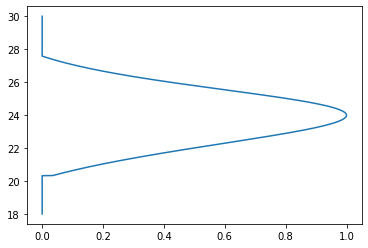

In [ ]:
plt.plot(Profiles_Dataset["Probability6"], Profiles_Dataset["Temperature6"])

In [ ]:
temp["Thermal Sensitivity"] = None
for t in range(96):
  p = np.round(temp["LIVING_UNIT1:Zone Mean Air Temperature [C](TimeStep)"][t],1)
  if p > 30:
    temp["Thermal Sensitivity"][t] = 0
  else:
    temp["Thermal Sensitivity"][t] = float(Profiles_Dataset["Probability6"][Profiles_Dataset["Temperature6"] == p])

temp["Thermal Sensitivity"].sum()/96

0.8627534375000003

#### Comfort with fixed on 23

In [ ]:
temp

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),LIVING_UNIT1:Zone People Occupant Count [](TimeStep),LIVING_UNIT1:Zone Mean Air Temperature [C](TimeStep),ATTIC_UNIT1:Zone Mean Air Temperature [C](TimeStep),LIVING_UNIT1:Zone Air System Sensible Heating Energy [J](TimeStep),LIVING_UNIT1:Zone Air System Sensible Cooling Energy [J](TimeStep),LIVING_UNIT1:Zone Thermostat Cooling Setpoint Temperature [C](TimeStep),ATTIC_UNIT1:Zone Air System Sensible Heating Energy [J](TimeStep),ATTIC_UNIT1:Zone Air System Sensible Cooling Energy [J](TimeStep),ATTIC_UNIT1:Zone Thermostat Cooling Setpoint Temperature [C](TimeStep),HTGSETP_SCH:Schedule Value [](TimeStep),CLGSETP_SCH:Schedule Value [](TimeStep),MAIN ELECTRIC HEATING COIL_UNIT1:Heating Coil Heating Energy [J](Hourly),DX COOLING COIL_UNIT1:Cooling Coil Total Cooling Energy [J](TimeStep),CENTRAL SYSTEM_UNIT1:Air System Electricity Energy [J](TimeStep),Averaged Building Temperature:PythonPlugin:OutputVariable [C](TimeStep),Month,Day,Hour,Minutes,Thermal Sensitivity
0,08/01 00:15:00,25.85,3.00000,22.459154,23.411899,0.0,3.320453e+06,22.0,0.0,0.0,0.0,15.0,22.0,NaN,5.872667e+06,0.400107,0.0,8,1,0,15,0.67126
1,08/01 00:30:00,25.60,3.00000,23.767236,23.215258,0.0,0.000000e+00,25.0,0.0,0.0,0.0,15.0,25.0,NaN,0.000000e+00,0.000000,0.0,8,1,0,30,0.99289
2,08/01 00:45:00,25.35,3.00000,24.023510,22.949246,0.0,1.513628e+06,24.0,0.0,0.0,0.0,15.0,24.0,NaN,2.613497e+06,0.191602,0.0,8,1,0,45,0.99998
3,08/01 01:00:00,25.10,3.00000,24.350736,22.741899,0.0,0.000000e+00,25.0,0.0,0.0,0.0,15.0,25.0,0.0,0.000000e+00,0.000000,0.0,8,1,1,0,0.96579
4,08/01 01:15:00,25.05,2.69079,23.983235,22.381469,0.0,1.008096e+06,24.0,0.0,0.0,0.0,15.0,24.0,NaN,1.799459e+06,0.126588,0.0,8,1,1,15,0.99998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,08/01 23:00:00,26.10,2.69079,23.095858,25.333007,0.0,2.764837e+06,23.0,0.0,0.0,0.0,15.0,23.0,0.0,4.536308e+06,0.319414,0.0,8,1,23,0,0.86211
92,08/01 23:15:00,26.10,3.00000,23.001702,24.706795,0.0,2.369748e+06,23.0,0.0,0.0,0.0,15.0,23.0,NaN,3.820679e+06,0.280161,0.0,8,1,23,15,0.83347
93,08/01 23:30:00,26.10,3.00000,23.855313,24.286977,0.0,7.999862e+05,24.0,0.0,0.0,0.0,15.0,24.0,NaN,1.262828e+06,0.093983,0.0,8,1,23,30,0.9984
94,08/01 23:45:00,26.10,3.00000,23.998797,23.972911,0.0,1.121602e+06,24.0,0.0,0.0,0.0,15.0,24.0,NaN,1.783383e+06,0.136031,0.0,8,1,23,45,0.99998


In [ ]:
temp["Thermal Sensitivity"] = None
for t in range(96):
  p = np.round(temp["LIVING_UNIT1:Zone Mean Air Temperature [C](TimeStep)"][t],1)
  if p > 30:
    temp["Thermal Sensitivity"][t] = 0
  else:
    temp["Thermal Sensitivity"][t] = float(Profiles_Dataset["Probability2"][Profiles_Dataset["Temperature2"] == p])

In [ ]:
temp["Thermal Sensitivity"].sum()/96

0.9437451041666676